In [1]:
import os
import sys
import shutil
import warnings
import numpy as np
import cv2
from tqdm import tqdm_notebook
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
warnings.simplefilter('ignore')

from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from keras.models import load_model
import keras.backend as K
from keras.utils import Sequence
from keras.layers import Reshape, Lambda
from keras.models import Model
import tensorflow as tf

import keras_segmentation

from albumentations import (
    Compose, OneOf, Rotate,
    RandomBrightness, IAAAdditiveGaussianNoise, GaussNoise,
    OpticalDistortion, GridDistortion, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, HueSaturationValue,
    HorizontalFlip, Normalize, RandomGamma, RGBShift,
    Blur, MedianBlur, CLAHE, ToGray, JpegCompression,
    RandomSizedCrop
)

from pascal_voc_data import PascalVocGenerator
from utils import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
height = 224
width = 224
num_classes = len(PascalVocGenerator.classes)
repeat_num = 1
batch_size = 40
epoch_nums = 300

train_aug = Compose([
    OneOf([
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ], p=0.5),
    OneOf([
        GaussNoise(),
        HueSaturationValue(),
        RGBShift()
    ], p=0.5),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        Blur(),
        MedianBlur()
    ], p=0.4),
    OneOf([
        CLAHE(),
        ToGray(),
        JpegCompression()
    ], p=0.2),
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    Normalize(p=1),
])

val_aug = Compose([
    Normalize(p=1)
])

logdir = os.path.join('logs', '{}_epochs_{}_bs_{}x{}'.format(epoch_nums, batch_size, height, width))
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.makedirs(logdir)
os.path.join(os.getcwd()[13:], logdir)

'neural_networks/UNet/logs/300_epochs_40_bs_224x224'

In [3]:
def reduce_lr(epoch, lr):
    if epoch % 100 == 0:
        return lr * 0.1
    else:
        return lr

train_generator_aug = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/train.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, train_aug, repeat_num
)
val_generator_aug = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/val.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, val_aug, 1
)

class modify_gen(Sequence):
    def __init__(self, gen):
        self.gen = gen
        
    def __len__(self):
        return self.gen.__len__()
        
    def __getitem__(self, idx):
        x, y = self.gen[idx]
        y_resh = np.array([cv2.resize(_y, (height // 2, width // 2), cv2.INTER_NEAREST).reshape(-1, 21) for _y in y])
        return x, y_resh

train_gen = modify_gen(train_generator_aug)
val_gen = modify_gen(val_generator_aug)

In [4]:
model = keras_segmentation.models.unet.mobilenet_unet(num_classes, height, width)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [5]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [7]:
history = model.fit_generator(
    train_gen, validation_data=val_gen,
    epochs=epoch_nums, verbose=1,
    callbacks=[
        TensorBoard(log_dir=logdir, batch_size=batch_size, write_graph=False, write_images=True),
        LearningRateScheduler(reduce_lr)
#         EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/300
37/37 [==============================] - 92s 2s/step - loss: 1.9535 - categorical_accuracy: 0.5585 - val_loss: 1.8993 - val_categorical_accuracy: 0.6474
Epoch 2/300
37/37 [==============================] - 68s 2s/step - loss: 1.2699 - categorical_accuracy: 0.7286 - val_loss: 1.0471 - val_categorical_accuracy: 0.7674
Epoch 3/300
37/37 [==============================] - 68s 2s/step - loss: 1.0469 - categorical_accuracy: 0.7653 - val_loss: 0.9760 - val_categorical_accuracy: 0.7847
Epoch 4/300
37/37 [==============================] - 69s 2s/step - loss: 0.9125 - categorical_accuracy: 0.7849 - val_loss: 0.9325 - val_categorical_accuracy: 0.7908
Epoch 5/300
37/37 [==============================] - 68s 2s/step - loss: 0.8359 - categorical_accuracy: 0.7971 - val_loss: 0.8819 - val_categorical_accuracy: 0.7990
Epoch 6/300
37/37 [==============================] - 69s 2s/step - loss: 0.7777 - categorical_accuracy: 0.8053 - val_loss: 0.8246 - val_categorical_accuracy: 0.8051
Epoch 7/30

KeyboardInterrupt: 

In [15]:
reshape = Reshape((height // 2, width // 2, 21))(model.get_layer('activation_1').output)
upsample = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='predictions')(reshape)
model_pred = Model(inputs=model.input, outputs=[upsample])

In [19]:
model_pred.save('110_epochs_fine_tuning.h5')

In [4]:
def relu6(x):
    return K.relu(x, max_value=6)

K.set_learning_phase(0)
model_pred = load_model(
    '110_epochs_fine_tuning.h5',
    custom_objects={
        'relu6': relu6,
        'tf': tf
    }
)
model_pred.inputs, model_pred.outputs

Instructions for updating:
Colocations handled automatically by placer.


([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>],
 [<tf.Tensor 'predictions/ResizeBilinear:0' shape=(?, 224, 224, 21) dtype=float32>])

In [22]:
iou = []
for img, true_mask in tqdm_notebook(val_generator_aug):
    pred = model_pred.predict(img)
    for i in range(len(pred)):
        pred_mask = softmax2classes(pred[i], height=height, width=width)
        iou.append(get_iou(true_mask[i], pred_mask)[0])
    break
np.mean(iou)

0.17621530600815438

0.2609707474705312


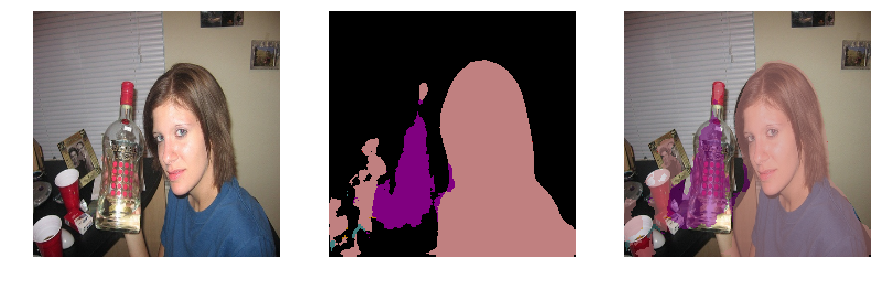

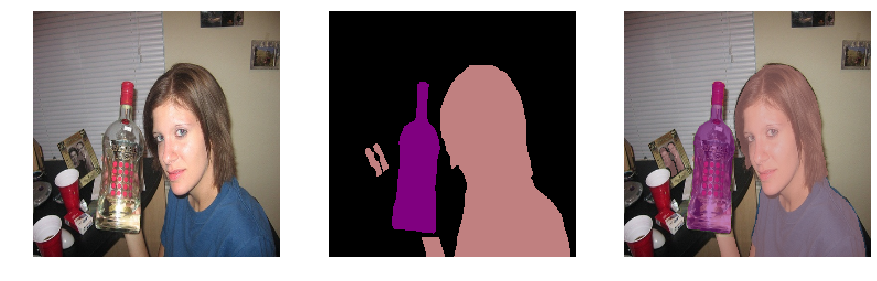

In [34]:
image_num = 9
pred_mask = softmax2classes(pred[image_num], height=height, width=width)
print(get_iou(true_mask[image_num], pred_mask)[0])
pred_mask_color = train_generator_aug.categorical_to_mask(pred_mask)
true_mask_color = train_generator_aug.categorical_to_mask(true_mask[image_num])
cur_img = (
    (img[image_num] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)) * 255
).astype(np.int)
PascalVocGenerator.segmentation_plot(cur_img, pred_mask_color).show()
PascalVocGenerator.segmentation_plot(cur_img, true_mask_color).show()

In [5]:
freeze_graph = freeze_session(K.get_session(), output_names=['predictions/ResizeBilinear'], quantize=False)
tf.train.write_graph(freeze_graph, '.', 'UNet_224x224.pb', as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 141 variables.
INFO:tensorflow:Converted 141 variables to const ops.


'./UNet_224x224.pb'

In [6]:
from tensorflow.lite.python.convert import OpsSet
converter = tf.lite.TFLiteConverter.from_frozen_graph(
    'UNet_224x224.pb', input_arrays=['input_1'],
    output_arrays=['predictions/ResizeBilinear'], input_shapes={'input_1': (1, 224, 224, 3)}
)
converter.allow_custom_ops = True
tflite_model = converter.convert()
open('UNet_224x224.tflite', 'wb').write(tflite_model)

25219628